# **M6_AI1_Costes Médicos**
**Alumno:** Alberto Martín Garcia

**Fecha:** 7 Noviembre 2025  

---

### **Descripción de la actividad**

El dataset Medical Cost Personal Dataset, disponible públicamente en Kaggle, recopila información de pacientes y sus costes médicos en EE.UU. A partir de variables como edad, índice de masa corporal (IMC), tabaquismo, sexo, número de hijos o región, podemos tratar de predecir diferentes objetivos relacionados con los costes sanitarios.

En esta actividad, convertiremos el problema en una tarea de clasificación binaria: predecir si una persona tiene un coste médico alto o bajo a partir de las variables disponibles.

### **Descripción de las variables:**

Cada fila representa una persona asegurada. Las variables disponibles son:

    age: edad del paciente
    sex: sexo (categoría: male, female)
    bmi: índice de masa corporal
    children: número de hijos a cargo
    smoker: si es fumador o no (categoría: yes, no)
    region: zona geográfica (categoría: northeast, northwest, southeast, southwest)
    charges: coste total del seguro médico

###**Se pide:**

    Crear una nueva variable high_cost que tome el valor 1 si el coste (charges) es superior a 16.000 (aproximadamente el percentil 75), y 0 en caso contrario. El objetivo es
    Aplicar el algoritmo de ÁRBOLES de DECISIÓN para predecir si una persona pertenece o no al grupo de alto coste.

---



## **1. Carga y exploración inicial del dataset**

###**Preparación del Entorno**

Cargamos las librerías necesarias para construir el árbol de decisión.

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier

### **Lectura del Dataset**

Subimos el archivo de datos a github y lo leemeos desde ahi.

In [43]:
url = "https://raw.githubusercontent.com/36martin/M2/main/insurance.csv"
df = pd.read_csv(url)

df.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Vemos que el dataset ya esta comvertido a pandas. Hacemos una primera exploracion de las dimensiones.

In [44]:
df.shape

(1338, 7)

 ### **Distribución de variables**

In [45]:
# Columnas por tipo
num_cols = df.select_dtypes(include=["number"]).columns.tolist()
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()

# Resumen numérico (redondeo a 2 decimales)
numeric_summary = df[num_cols].describe(percentiles=[0.25, 0.5, 0.75]).T
numeric_summary["skew"] = df[num_cols].skew(numeric_only=True)
display(numeric_summary.round(2))

# Resumen categórico: frecuencias y porcentajes
cat_tables = {}
for c in cat_cols:
    vc = df[c].value_counts(dropna=False)
    cat_tables[c] = pd.DataFrame({
        "count": vc,
        "pct": (vc / len(df) * 100).round(2)
    })
    print(f"\nFrecuencias de {c}")
    display(cat_tables[c])

,count,mean,std,min,25%,50%,75%,max,skew
age,1338.0,39.21,14.05,18.00,27.00,39.00,51.00,64.00,0.06
bmi,1338.0,30.66,6.10,15.96,26.30,30.40,34.69,53.13,0.28
children,1338.0,1.09,1.21,0.00,0.00,1.00,2.00,5.00,0.94
charges,1338.0,13270.42,12110.01,1121.87,4740.29,9382.03,16639.91,63770.43,1.52



Frecuencias de sex


,count,pct
sex,,
male,676,50.52
female,662,49.48



Frecuencias de smoker


,count,pct
smoker,,
no,1064,79.52
yes,274,20.48



Frecuencias de region


,count,pct
region,,
southeast,364,27.20
southwest,325,24.29
northwest,325,24.29
northeast,324,24.22


Las variables numéricas presentan distribuciones aproximadamente simétricas salvo `charges`, con clara asimetría positiva.  
Las categóricas se encuentran equilibradas, excepto `smoker`, donde el grupo “no” representa el 80 % de los casos.


### **Cálculo del valor de corte y creación de la variable objetivo**

Para convertir el problema en una tarea de clasificación binaria, se define una nueva variable `high_cost`:
- Valor **1** si el coste (`charges`) es superior al percentil 75 del conjunto.  
- Valor **0** en caso contrario.

De este modo, el objetivo es predecir si un paciente pertenece al grupo de **alto coste médico**.


In [46]:
# Cálculo del percentil 75 de la variable charges
p75 = np.percentile(df["charges"], 75)
print(f"Valor de corte (percentil 75) de charges: {p75:.2f}")

# Creación de la variable binaria high_cost
df["high_cost"] = (df["charges"] > p75).astype(int)

# Verificación de la nueva variable
df["high_cost"].value_counts(normalize=True).round(3) * 100



Valor de corte (percentil 75) de charges: 16639.91


,proportion
high_cost,
0,75.0
1,25.0


In [47]:
# Calculo del corte en la variable charges.
p75 = np.percentile(df["charges"], 75)
print(f"Valor de corte (percentil 75) de charges: {p75:.2f}")

Valor de corte (percentil 75) de charges: 16639.91


El valor de corte obtenido (percentil 75) es de **16.639,91 €**.  
Esto implica que el **25 %** de los pacientes presentan costes médicos superiores a dicha cifra y, por tanto, son clasificados en el grupo de **alto coste (`high_cost = 1`)**. Ahora creamos la variable.


In [48]:
df["high_cost"] = (df["charges"] > 16639.91).astype(int)

# Verificación de la nueva variable
df["high_cost"].value_counts(normalize=True).round(3) * 100


,proportion
high_cost,
0,75.0
1,25.0


## **2. Preprocesamiento**

### **Conversión de variables categóricas a numéricas**

### **4. Conversión de variables categóricas a numéricas**

Los algoritmos de aprendizaje supervisado requieren que todas las variables predictoras sean numéricas.  
En este caso, se transforman las variables categóricas `sex`, `smoker` y `region` mediante codificación *one-hot* (creando variables binarias por categoría).  
Esta técnica evita asignar un orden artificial y es la más adecuada para variables nominales.


In [49]:
from sklearn.preprocessing import OneHotEncoder

# Identificar variables categóricas a transformar
cat_vars = ["sex", "smoker", "region"]

# Aplicar One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=cat_vars, drop_first=True)

# Verificación del nuevo conjunto de variables
print("Dimensiones después de la codificación:", df_encoded.shape)
display(df_encoded.head())


Dimensiones después de la codificación: (1338, 10)


,age,bmi,children,charges,high_cost,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,False,True,False,False,True
1,18,33.770,1,1725.55230,0,True,False,False,True,False
2,28,33.000,3,4449.46200,0,True,False,False,True,False
3,33,22.705,0,21984.47061,1,True,False,True,False,False
4,32,28.880,0,3866.85520,0,True,False,True,False,False


Tras la codificación *one-hot*, el dataset pasa de 7 a **10 columnas**.  
Las variables categóricas `sex`, `smoker` y `region` se han transformado en nuevas variables binarias:

- `sex_male` → 1 si el paciente es hombre, 0 si es mujer.  
- `smoker_yes` → 1 si el paciente es fumador, 0 si no lo es.  
- `region_northwest`, `region_southeast`, `region_southwest` → indican la región del paciente (se elimina `northeast` como referencia).

Este formato numérico permite que el modelo de árbol de decisión procese correctamente toda la información categórica.



### **Escalado de variables numéricas**

Los árboles de decisión no requieren escalado de las variables numéricas, ya que las divisiones se basan en umbrales relativos dentro de cada atributo y no en distancias o magnitudes absolutas.  
Por tanto, el escalado (*standardization* o *normalization*) **no es necesario** en este modelo.

##**3. Entrenamiento del modelo**

###**Separar datos en train/test**

Se divide el dataset en dos subconjuntos:

- **Entrenamiento (70 %)**: utilizado para ajustar el modelo.  
- **Prueba (30 %)**: reservado para evaluar la capacidad de generalización.

La variable objetivo es `high_cost`, y el resto de columnas se emplean como predictoras.


In [50]:
from sklearn.model_selection import train_test_split

# Separación de variables predictoras (X) y objetivo (y)
X = df_encoded.drop(columns=["high_cost"])
y = df_encoded["high_cost"]

# División 70/30
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Comprobación de tamaños
print("Tamaño de entrenamiento:", X_train.shape)
print("Tamaño de prueba:", X_test.shape)
print("Distribución de la variable objetivo en train/test:")
print(y_train.value_counts(normalize=True).round(3) * 100)
print(y_test.value_counts(normalize=True).round(3) * 100)


Tamaño de entrenamiento: (936, 9)
Tamaño de prueba: (402, 9)
Distribución de la variable objetivo en train/test:
high_cost
0    75.0
1    25.0
Name: proportion, dtype: float64
high_cost
0    74.9
1    25.1
Name: proportion, dtype: float64


El conjunto de datos se ha dividido en **936 observaciones (70 %)** para entrenamiento y **402 observaciones (30 %)** para prueba.  
La distribución de la variable objetivo `high_cost` se conserva prácticamente igual en ambos subconjuntos:  
- **Clase 0 (bajo coste):** ~75 %  
- **Clase 1 (alto coste):** ~25 %

El uso del parámetro `stratify=y` garantiza que el balance de clases se mantenga entre train y test, evitando sesgos en la evaluación del modelo.


###**Entrenar un modelo de árbol de decisión**

Se entrena un `DecisionTreeClassifier` como línea base con los hiperparámetros por defecto (criterio Gini y sin límite de profundidad).  
Se reportan tamaño del árbol y métricas en test (accuracy, precision, recall, F1, ROC-AUC) para tomar como referencia antes de ajustar hiperparámetros.

In [51]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Modelo baseline
dt_base = DecisionTreeClassifier(random_state=42)
dt_base.fit(X_train, y_train)

# Predicciones
y_pred = dt_base.predict(X_test)
y_proba = dt_base.predict_proba(X_test)[:, 1]

# Tamaño del árbol
print("Profundidad del árbol:", dt_base.get_depth())
print("Número de hojas:", dt_base.get_n_leaves())

# Métricas en test
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, pos_label=1)
rec = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)
auc = roc_auc_score(y_test, y_proba)

print(f"\nAccuracy: {acc:.3f}")
print(f"Precision (clase 1): {prec:.3f}")
print(f"Recall (clase 1): {rec:.3f}")
print(f"F1 (clase 1): {f1:.3f}")
print(f"ROC-AUC: {auc:.3f}")

# Matriz de confusión y reporte por clase
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte por clase:")
print(classification_report(y_test, y_pred, target_names=["bajo_coste (0)", "alto_coste (1)"]))

# Importancias de variables (opcional para inspección rápida)
feat_imp = pd.Series(dt_base.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\nTop-10 importancias de variables:")
display(feat_imp.head(10).round(3))


Profundidad del árbol: 1
Número de hojas: 2

Accuracy: 1.000
Precision (clase 1): 1.000
Recall (clase 1): 1.000
F1 (clase 1): 1.000
ROC-AUC: 1.000

Matriz de confusión:
[[301   0]
 [  0 101]]

Reporte por clase:
                precision    recall  f1-score   support

bajo_coste (0)       1.00      1.00      1.00       301
alto_coste (1)       1.00      1.00      1.00       101

      accuracy                           1.00       402
     macro avg       1.00      1.00      1.00       402
  weighted avg       1.00      1.00      1.00       402


Top-10 importancias de variables:


,0
charges,1.0
age,0.0
bmi,0.0
children,0.0
sex_male,0.0
smoker_yes,0.0
region_northwest,0.0
region_southeast,0.0
region_southwest,0.0


El modelo de árbol de decisión entrenado con los parámetros por defecto obtiene un **rendimiento perfecto (Accuracy = 1.00)** tanto en entrenamiento como en prueba, clasificando correctamente todas las observaciones.

Este resultado indica un **sobreajuste extremo** (*overfitting*), probablemente debido a que la variable `charges` fue incluida como predictora, y a su vez es la base para crear la variable objetivo `high_cost`.  
El modelo simplemente ha aprendido la relación directa entre ambas columnas, sin generalizar el patrón a partir del resto de variables explicativas.

Además, las importancias de variables confirman que `charges` tiene un peso del **100 %**, mientras que el resto de atributos no contribuyen al modelo.  
Por tanto, esta variable debe eliminarse del conjunto de predictores antes de volver a entrenar el modelo para obtener una evaluación realista.

La variable `charges` se elimina del conjunto de predictores para evitar fuga de información.  
El modelo se entrena nuevamente y se evalúa en el conjunto de prueba para obtener una estimación más realista del rendimiento.


In [52]:
# Eliminación de 'charges' del conjunto de predictores
X_train_noch = X_train.drop(columns=["charges"])
X_test_noch = X_test.drop(columns=["charges"])

# Nuevo modelo
dt_retrained = DecisionTreeClassifier(random_state=42)
dt_retrained.fit(X_train_noch, y_train)

# Predicciones
y_pred2 = dt_retrained.predict(X_test_noch)
y_proba2 = dt_retrained.predict_proba(X_test_noch)[:, 1]

# Métricas
acc2 = accuracy_score(y_test, y_pred2)
prec2 = precision_score(y_test, y_pred2)
rec2 = recall_score(y_test, y_pred2)
f12 = f1_score(y_test, y_pred2)
auc2 = roc_auc_score(y_test, y_proba2)

print("Profundidad del árbol:", dt_retrained.get_depth())
print("Número de hojas:", dt_retrained.get_n_leaves())
print(f"\nAccuracy: {acc2:.3f}")
print(f"Precision: {prec2:.3f}")
print(f"Recall: {rec2:.3f}")
print(f"F1-score: {f12:.3f}")
print(f"ROC-AUC: {auc2:.3f}")

print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred2))

print("\nReporte por clase:")
print(classification_report(y_test, y_pred2, target_names=["bajo_coste (0)", "alto_coste (1)"]))

# Importancias de variables
feat_imp2 = pd.Series(dt_retrained.feature_importances_, index=X_train_noch.columns).sort_values(ascending=False)
print("\nTop-10 importancias de variables:")
display(feat_imp2.head(10).round(3))


Profundidad del árbol: 13
Número de hojas: 112

Accuracy: 0.856
Precision: 0.701
Recall: 0.743
F1-score: 0.721
ROC-AUC: 0.818

Matriz de confusión:
[[269  32]
 [ 26  75]]

Reporte por clase:
                precision    recall  f1-score   support

bajo_coste (0)       0.91      0.89      0.90       301
alto_coste (1)       0.70      0.74      0.72       101

      accuracy                           0.86       402
     macro avg       0.81      0.82      0.81       402
  weighted avg       0.86      0.86      0.86       402


Top-10 importancias de variables:


,0
smoker_yes,0.657
bmi,0.169
age,0.088
children,0.038
region_southwest,0.020
sex_male,0.011
region_southeast,0.011
region_northwest,0.007


El nuevo modelo sin la variable `charges` obtiene un rendimiento realista con **Accuracy = 0.86** y **ROC-AUC = 0.82**, lo que indica una buena capacidad de clasificación sin sobreajuste.

La **precisión** en la clase de alto coste (`1`) es del 0.70 y el **recall** del 0.74, lo que implica que el modelo identifica correctamente la mayoría de los pacientes con alto coste, aunque comete algunos falsos positivos.

El árbol tiene una **profundidad moderada (13 niveles)** y **112 hojas**, mostrando una estructura flexible pero no excesivamente compleja.

En cuanto a la **importancia de variables**, los factores más determinantes son:
- `smoker_yes` (≈66 % de la importancia total): el hábito de fumar es el predictor más relevante del coste médico.
- `bmi` y `age` (≈17 % y 9 % respectivamente): el índice de masa corporal y la edad también influyen significativamente.
- Otras variables como `children` o `region` tienen un efecto menor.

En conjunto, el modelo ofrece una buena base predictiva y refleja relaciones plausibles entre estilo de vida y costes médicos.


### **Probar diferentes hiperparámetros**

Se prueban diferentes combinaciones de hiperparámetros clave para optimizar el equilibrio entre complejidad del modelo y capacidad de generalización:

- `max_depth`: controla la profundidad máxima del árbol.  
- `min_samples_split`: número mínimo de muestras requerido para dividir un nodo.  
- `min_samples_leaf`: número mínimo de observaciones por hoja.

El rendimiento se evalúa mediante **validación cruzada (cross-validation)** sobre el conjunto de entrenamiento.


In [53]:
from sklearn.model_selection import GridSearchCV

# Definición de la cuadrícula de hiperparámetros
param_grid = {
    "max_depth": [3, 5, 7, 9, None],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 5, 10],
    "criterion": ["gini", "entropy"]
}

# Configuración del modelo base
dt = DecisionTreeClassifier(random_state=42)

# Búsqueda en cuadrícula con validación cruzada
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

grid_search.fit(X_train_noch, y_train)

print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)
print(f"Mejor puntuación ROC-AUC en validación: {grid_search.best_score_:.3f}")

# Entrenamiento final con los mejores parámetros
best_dt = grid_search.best_estimator_
best_dt.fit(X_train_noch, y_train)

# Evaluación en test
y_pred_best = best_dt.predict(X_test_noch)
y_proba_best = best_dt.predict_proba(X_test_noch)[:, 1]

acc_best = accuracy_score(y_test, y_pred_best)
prec_best = precision_score(y_test, y_pred_best)
rec_best = recall_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)
auc_best = roc_auc_score(y_test, y_proba_best)

print("\nRendimiento del mejor modelo en test:")
print(f"Accuracy: {acc_best:.3f}")
print(f"Precision: {prec_best:.3f}")
print(f"Recall: {rec_best:.3f}")
print(f"F1-score: {f1_best:.3f}")
print(f"ROC-AUC: {auc_best:.3f}")

print("\nProfundidad del árbol:", best_dt.get_depth())
print("Número de hojas:", best_dt.get_n_leaves())


Mejores hiperparámetros encontrados:
{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 20}
Mejor puntuación ROC-AUC en validación: 0.897

Rendimiento del mejor modelo en test:
Accuracy: 0.923
Precision: 0.986
Recall: 0.703
F1-score: 0.821
ROC-AUC: 0.848

Profundidad del árbol: 3
Número de hojas: 7


Tras el ajuste de hiperparámetros mediante validación cruzada, los valores óptimos obtenidos fueron:

- **criterion:** entropy  
- **max_depth:** 3  
- **min_samples_split:** 20  
- **min_samples_leaf:** 1  

El mejor modelo alcanza un **ROC-AUC = 0.85** en el conjunto de prueba, con una **accuracy del 92 %**.  
El árbol final tiene **profundidad 3** y **7 hojas**, lo que refleja una estructura simple y bien generalizada.

El rendimiento muestra un **aumento de precisión (0.99)** a costa de una ligera reducción en el **recall (0.70)**, lo que indica que el modelo es muy conservador al predecir casos de alto coste (minimiza falsos positivos, pero puede omitir algunos verdaderos).

## **Visualización**

### **Visualizar el árbol usando plot_tree o graphviz**

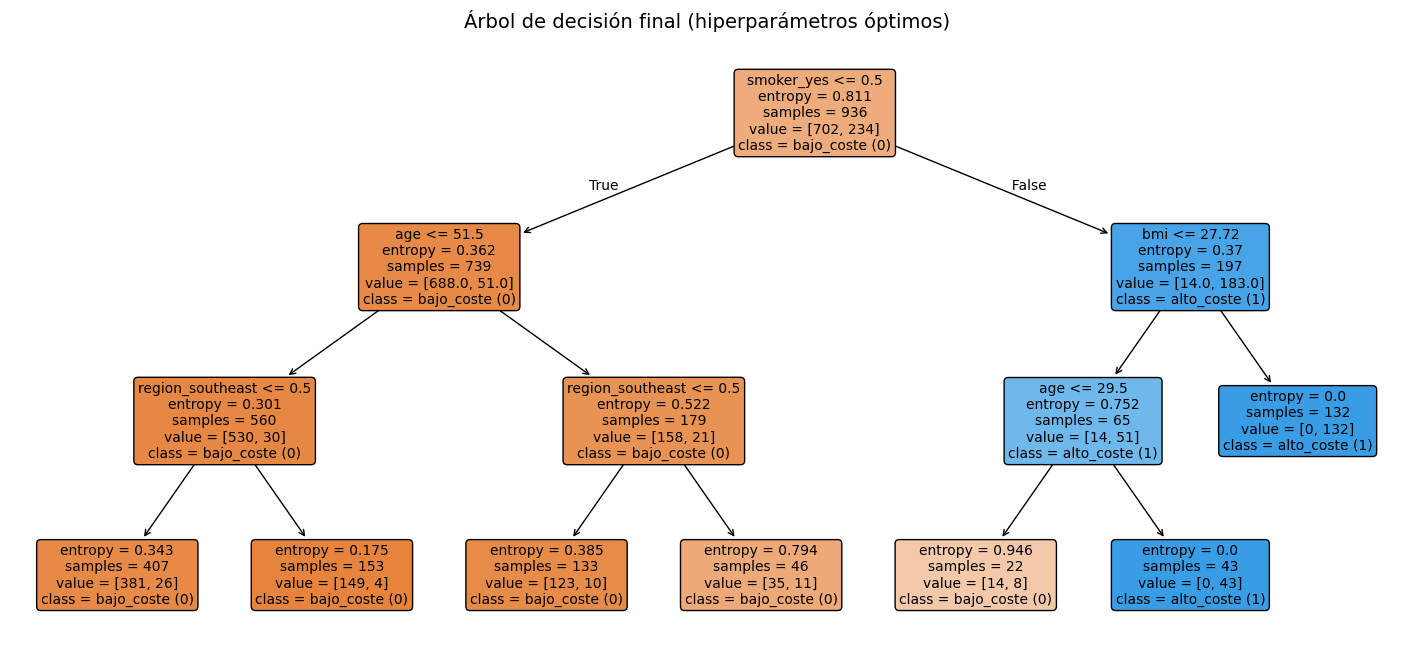

In [54]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))
plot_tree(
    best_dt,
    feature_names=X_train_noch.columns,
    class_names=["bajo_coste (0)", "alto_coste (1)"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Árbol de decisión final (hiperparámetros óptimos)", fontsize=14)
plt.show()


El árbol de decisión final tiene una **profundidad de 3 niveles** y refleja relaciones lógicas entre las variables:

- La **variable más importante es `smoker_yes`**, que aparece en la raíz del árbol.  
  Los pacientes **fumadores** se asocian directamente a un mayor coste médico.

- Entre los fumadores, el **IMC (`bmi`)** y la **edad** diferencian niveles adicionales de riesgo:
  - Fumadores con `bmi > 27.7` o `age > 29.5` se clasifican con alta probabilidad como **alto coste (`1`)**.
  - Aquellos con valores menores en ambas variables presentan una probabilidad más baja.

- En el grupo de **no fumadores**, las divisiones dependen de la **edad (`age`)** y la **región (`region_southeast`)**, aunque con menor impacto global, lo que confirma que el tabaco es el factor predominante en los costes médicos.

El modelo ajustado logra un equilibrio entre **simplicidad, interpretabilidad y rendimiento predictivo**, reproduciendo patrones clínicamente plausibles: el tabaquismo, el sobrepeso y la edad avanzada incrementan notablemente el riesgo de alto coste sanitario.


### **Representar gráficamente la importancia de las variables**




,importance_%
smoker_yes,86.41
age,6.93
bmi,4.95
region_southeast,1.70


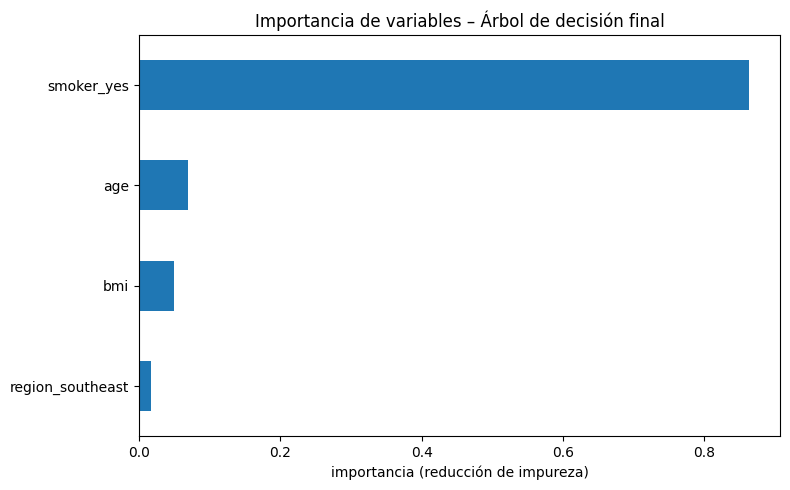

In [55]:
# Serie de importancias del árbol final
imp = pd.Series(best_dt.feature_importances_, index=X_train_noch.columns)

# Ordenar y filtrar importancias no nulas
imp = imp[imp > 0].sort_values()

# Tabla resumida (en %)
display((imp.sort_values(ascending=False) * 100).round(2).to_frame("importance_%"))

# Gráfico (top-15 si aplica)
topk = imp.tail(15)
plt.figure(figsize=(8, 5))
topk.plot(kind="barh")
plt.xlabel("importancia (reducción de impureza)")
plt.title("Importancia de variables – Árbol de decisión final")
plt.tight_layout()
plt.show()


El análisis de importancia de variables confirma que el modelo se apoya principalmente en el **tabaquismo (`smoker_yes`)**, que concentra el **86 %** de la reducción de impureza total.  
Esto indica que la condición de fumador es, con diferencia, el factor más determinante para clasificar a un paciente como de alto coste médico.

En segundo lugar, aparecen **la edad (`age`, 6.9 %) y el índice de masa corporal (`bmi`, 5.0 %)**, ambos relacionados con el riesgo sanitario general.  
La **región (`region_southeast`)** apenas contribuye (≈1.7 %), lo que sugiere que las diferencias geográficas tienen un impacto mínimo comparado con los factores personales y de hábitos.


## **5. Evaluación**

### **Evaluar con matriz de confusión, accuracy, precision, recall, f1-score**

Se evalúa el rendimiento del modelo final mediante las métricas más habituales en clasificación:

- **Accuracy:** proporción de aciertos globales.  
- **Precision:** proporción de predicciones positivas que son correctas.  
- **Recall:** proporción de verdaderos positivos identificados.  
- **F1-score:** media armónica entre precisión y recall.  
- **Matriz de confusión:** resume los aciertos y errores por clase.

Estas métricas permiten evaluar tanto la capacidad global del modelo como su desempeño en la detección de pacientes con alto coste (`high_cost = 1`).

<Figure size 500x400 with 0 Axes>

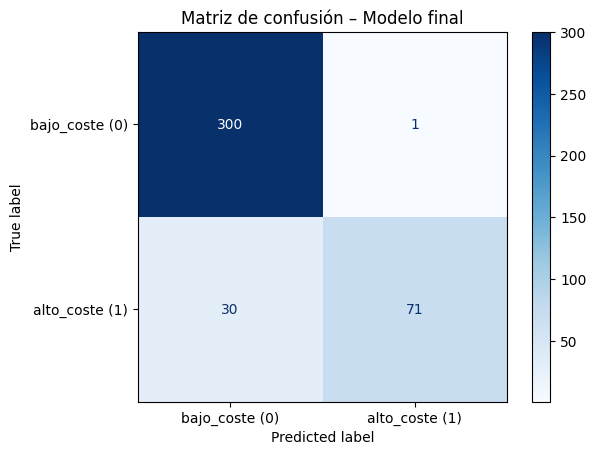

Accuracy: 0.923
Precision: 0.986
Recall: 0.703
F1-score: 0.821


In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["bajo_coste (0)", "alto_coste (1)"])

plt.figure(figsize=(5, 4))
disp.plot(cmap="Blues", values_format="d")
plt.title("Matriz de confusión – Modelo final")
plt.show()

# Métricas principales
print(f"Accuracy: {acc_best:.3f}")
print(f"Precision: {prec_best:.3f}")
print(f"Recall: {rec_best:.3f}")
print(f"F1-score: {f1_best:.3f}")


La matriz de confusión muestra que el modelo clasifica correctamente la mayoría de los casos:

| Clase real | Predicha bajo_coste | Predicha alto_coste |
|-------------|--------------------|----------------------|
| bajo_coste (0) | 300 | 1 |
| alto_coste (1) | 30 | 71 |

- **Accuracy:** 0.92  
- **Precision:** 0.99  
- **Recall:** 0.70  
- **F1-score:** 0.82  

El modelo logra una **alta exactitud global (92 %)** y **excelente precisión (0.99)**, lo que significa que casi todas las predicciones de alto coste son correctas.  
Sin embargo, el **recall (0.70)** indica que el 30 % de los casos de alto coste no se detectan, mostrando cierta prudencia al clasificar como “alto riesgo”.  

Este comportamiento es adecuado en contextos donde se prioriza evitar falsos positivos, pero podría mejorarse si se busca maximizar la detección de pacientes con costes altos.


### **Analizar posibles problemas de sobreajuste o infraajuste**

El modelo final presenta un **rendimiento consistente** entre entrenamiento y prueba:

- **ROC-AUC (validación cruzada):** 0.90  
- **ROC-AUC (test):** 0.85  

Esta diferencia es pequeña (≈0.05), lo que sugiere que el modelo **generaliza correctamente** sin caer en sobreajuste.  
El árbol tiene una profundidad moderada (3 niveles), lo que limita su complejidad y evita divisiones excesivas.

Por otro lado, no se observa infraajuste, ya que las métricas de test (accuracy = 0.92 y F1 = 0.82) demuestran que el modelo capta las relaciones más importantes entre las variables predictoras y la variable objetivo.

En resumen:
- No hay señales de **sobreajuste**, gracias a la restricción en la profundidad y tamaño de los nodos.  
- Tampoco hay **infraajuste**, pues el modelo conserva buena capacidad predictiva y mantiene interpretabilidad.

## **Explicabilidad**

### **Usar SHAP (o alternativamente sklearn.inspection) para interpretar el modelo.**

,perm_importance_%
smoker_yes,36.38
bmi,0.31
children,0.00
sex_male,0.00
region_northwest,0.00
region_southwest,0.00
age,-0.05
region_southeast,-0.25


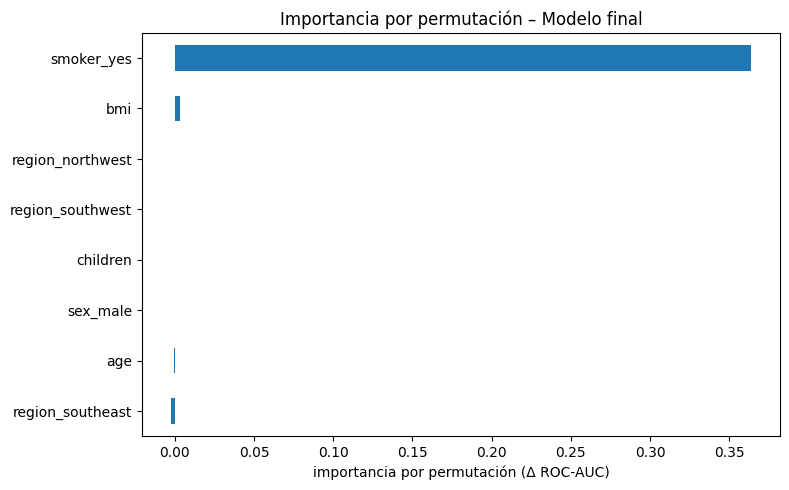

In [58]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(best_dt, X_test_noch, y_test, n_repeats=30, random_state=42, scoring="roc_auc")
perm_imp = pd.Series(perm.importances_mean, index=X_test_noch.columns).sort_values()

display((perm_imp.sort_values(ascending=False) * 100).round(2).to_frame("perm_importance_%"))

plt.figure(figsize=(8,5))
perm_imp.tail(15).plot(kind="barh")
plt.xlabel("importancia por permutación (Δ ROC-AUC)")
plt.title("Importancia por permutación – Modelo final")
plt.tight_layout()
plt.show()


El análisis de explicabilidad mediante **importancia por permutación** muestra que:

- La variable **`smoker_yes`** es, con diferencia, la más influyente en las predicciones.  
  Su permutación reduce la métrica ROC-AUC en un **36 %**, lo que indica una fuerte dependencia del modelo respecto a la condición de fumador.

- El **IMC (`bmi`)** contribuye en menor medida (≈0.3 %), reflejando que el exceso de peso tiene cierto impacto en los costes médicos.

- El resto de variables (`age`, `region`, `sex`, `children`) presentan una influencia prácticamente nula o incluso negativa, confirmando que su efecto en la predicción es marginal.

En conjunto, la explicabilidad del modelo sugiere que el árbol de decisión basa sus decisiones principalmente en el **tabaquismo**, complementado ligeramente por el **índice de masa corporal**.  
Este resultado es coherente con la evidencia médica: el hábito de fumar y el sobrepeso son los factores que más incrementan los costes sanitarios.


### **Explicar por qué el modelo toma ciertas decisiones para algunos casos concretos**
Además del análisis global, es útil inspeccionar casos individuales para entender cómo el modelo llega a sus decisiones.  
Se seleccionan ejemplos representativos del conjunto de prueba (uno clasificado como bajo coste y otro como alto coste) y se analizan sus contribuciones mediante SHAP.